In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Use GPU:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tensorflow as tf
import keras

tf.test.gpu_device_name()

''

Install StellarGraph:

In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 29.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.3 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.calibration import expected_calibration_error, plot_reliability_diagram
from stellargraph.calibration import IsotonicCalibration, TemperatureCalibration

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
from  stellargraph import StellarGraph
import pandas as pd


%matplotlib inline

Import data and split between years to predict and years to train:

In [ ]:
import numpy as np
from  stellargraph import StellarGraph
import pandas as pd

#load the data
author_codes = np.load("/content/drive/MyDrive/lfnproject/author_codes.npy", allow_pickle = True)
deg = np.load("/content/drive/MyDrive/lfnproject/deg.npy",allow_pickle = True)
har_cen = np.load("/content/drive/MyDrive/lfnproject/har_cen.npy",allow_pickle = True)
deg_cen = np.load("/content/drive/MyDrive/lfnproject/deg_cen.npy",allow_pickle = True)
clos_cen = np.load("/content/drive/MyDrive/lfnproject/clos_cen.npy",allow_pickle = True)
bet_cen = np.load("/content/drive/MyDrive/lfnproject/bet_cen.npy",allow_pickle = True)
load_cen = np.load("/content/drive/MyDrive/lfnproject/load_cen.npy",allow_pickle = True)
square_clus = np.load("/content/drive/MyDrive/lfnproject/square_clus.npy",allow_pickle = True)
pagerank = np.load("/content/drive/MyDrive/lfnproject/pagerank.npy",allow_pickle = True)
constr = np.load("/content/drive/MyDrive/lfnproject/constr.npy",allow_pickle = True)
nodes_index = np.load("/content/drive/MyDrive/lfnproject/nodes_index.npy",allow_pickle = True)
source = np.load("/content/drive/MyDrive/lfnproject/source.npy",allow_pickle = True)

target = np.load("/content/drive/MyDrive/lfnproject/target.npy",allow_pickle = True)
years = np.load("/content/drive/MyDrive/lfnproject/years.npy",allow_pickle = True)
collabs = np.load("/content/drive/MyDrive/lfnproject/collabs.npy",allow_pickle = True)
edge_load_cen = np.load("/content/drive/MyDrive/lfnproject/edge_load_cen.npy",allow_pickle = True)


source_train = []
target_train = []
years_train = []
collabs_train = []
edge_load_cen_train = []

source_test = []
target_test = []
years_test = []
collabs_test = []
edge_load_cen_test = []

for i in range(len(years)):  #put 2003 collaborations in the test set
  if(years[i] == 2003):
    years_test.append(years[i])
    source_test.append(source[i])
    target_test.append(target[i])
    collabs_test.append(collabs[i])
    edge_load_cen_test.append(edge_load_cen[i])
  else:
    years_train.append(years[i])
    source_train.append(source[i])
    target_train.append(target[i])
    collabs_train.append(collabs[i])
    edge_load_cen_train.append(edge_load_cen[i])
  

Split graph into train-val-test:

In [ ]:
square_node_data_train = pd.DataFrame( #data structure for the nodes
    {"author_code": author_codes,"degree":deg, "harmonic_centrality":har_cen, "degree_centrality":deg_cen, 
    "closeness_centrality": clos_cen, "betweenness_centrality":bet_cen, "load_centrality":load_cen,
     "square_clustering":square_clus, "pagerank": pagerank,  "constraint": constr},
     index = nodes_index)

square_edges_train = pd.DataFrame( #data structure for the edges
    {"source": source_train, "target": target_train, "year": years_train, "collab": collabs_train, "load_centrality": edge_load_cen_train}
)

G_train = StellarGraph(square_node_data_train, square_edges_train) #build graph
print(G_train.info())


square_node_data_test = pd.DataFrame( #data structure for the nodes
    {"author_code": author_codes,"degree":deg, "harmonic_centrality":har_cen, "degree_centrality":deg_cen, 
    "closeness_centrality": clos_cen, "betweenness_centrality":bet_cen, "load_centrality":load_cen,
     "square_clustering":square_clus, "pagerank": pagerank,  "constraint": constr},
     index = nodes_index)

square_edges_test = pd.DataFrame( #data structure for the edges
    {"source": source_test, "target": target_test, "year": years_test, "collab": collabs_test, "load_centrality": edge_load_cen_test}
)

G_test = StellarGraph(square_node_data_test, square_edges_test) #build graph
print(G_test.info())

# train, test, validation split
train_size = 0.4 
val_size = 0.1
test_size = 0.05

#sum of sizes doesn't sum up to 1 because since we want the splits
#to be connected we can't use 100% of the graph

# Define an edge splitter on the reduced graph G_train:
edge_splitter_test = EdgeSplitter(G_test)

# Randomly sample a fraction p=test_size of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_size, method="global", keep_connected=True)

edge_splitter_val = EdgeSplitter(G_train)

# Randomly sample a fraction p=val_size of all positive links, and same number of negative links, from G_train, and obtain the
# reduced graph G_val with the sampled links removed, that will be used to sample the train edges:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_size, method="global", keep_connected=True)


edge_splitter_train = EdgeSplitter(G_val)

G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_size, method="global", keep_connected=True)

StellarGraph: Undirected multigraph
 Nodes: 15410, Edges: 26702

 Node types:
  default: [15410]
    Features: float32 vector, length 10
    Edge types: default-default->default

 Edge types:
    default-default->default: [26702]
        Weights: all 1 (default)
        Features: float32 vector, length 3
StellarGraph: Undirected multigraph
 Nodes: 15410, Edges: 913

 Node types:
  default: [15410]
    Features: float32 vector, length 10
    Edge types: default-default->default

 Edge types:
    default-default->default: [913]
        Weights: all 1 (default)
        Features: float32 vector, length 3
** Sampled 45 positive and 45 negative edges. **
** Sampled 2670 positive and 2670 negative edges. **
** Sampled 9612 positive and 9612 negative edges. **


Train the model:

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

batch_size = 64
epochs = 100  

num_samples = [20, 10, 10]  #number of samples to use in the layers, respectively for 1,2 and 3-hop

#generate links for the training
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)

#we use 3 layers, respectively for 1,2 and 3-hop
layer_sizes = [16, 16, 16]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias = True, dropout=0.3)

x_inp, x_out = graphsage.in_out_tensors()

logits = link_classification(output_dim=1, output_act="elu", edge_embedding_method="ip")(x_out)

prediction = keras.layers.Activation(keras.activations.gelu)(logits)

model = keras.Model(inputs=x_inp, outputs=prediction)


model.compile(optimizer=Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val, shuffle = False)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test, shuffle = False)

history = model.fit(train_flow,steps_per_epoch = len(train_flow), epochs= epochs, callbacks=[reduce_lr, early_stop],validation_data = val_flow, validation_steps = len(val_flow),verbose=2)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/100
301/301 - 406s - loss: 0.7046 - accuracy: 0.5953 - val_loss: 0.6438 - val_accuracy: 0.6114 - lr: 0.0010 - 406s/epoch - 1s/step
Epoch 2/100
301/301 - 385s - loss: 0.6306 - accuracy: 0.6348 - val_loss: 0.6259 - val_accuracy: 0.6388 - lr: 0.0010 - 385s/epoch - 1s/step
Epoch 3/100
301/301 - 386s - loss: 0.6180 - accuracy: 0.6539 - val_loss: 0.6097 - val_accuracy: 0.6601 - lr: 0.0010 - 386s/epoch - 1s/step
Epoch 4/100
301/301 - 379s - loss: 0.6025 - accuracy: 0.6672 - val_loss: 0.6036 - val_accuracy: 0.6661 - lr: 0.0010 - 379s/epoch - 1s/step
Epoch 5/100
301/301 - 375s - loss: 0.5931 - accuracy: 0.6777 - val_loss: 0.6400 - val_accuracy: 0.6337 - lr: 0.0010 - 375s/epoch - 1s/step
Epoch 6/100
301/301 - 381s - loss: 0.5882 - accuracy: 0.6824 - val_loss: 0.5963 - val_accuracy: 0.6725 - lr: 0.0010 - 381s/epoch - 1s/step
Epoch 7/100
301/301 - 377s - loss: 0.5847 - accuracy: 0.6928 - val_loss: 0.5864

Evaluate model:

2/2 [==============================] - 1s 145ms/step - loss: 0.8511 - accuracy: 0.4556

Train Set Metrics of the trained model:
	loss: 0.5558
	accuracy: 0.7233

Validation Set Metrics of the trained model:
	loss: 0.5669
	accuracy: 0.6938

Test Set Metrics of the trained model:
	loss: 0.8511
	accuracy: 0.4556
2/2 [==============================] - 1s 145ms/step


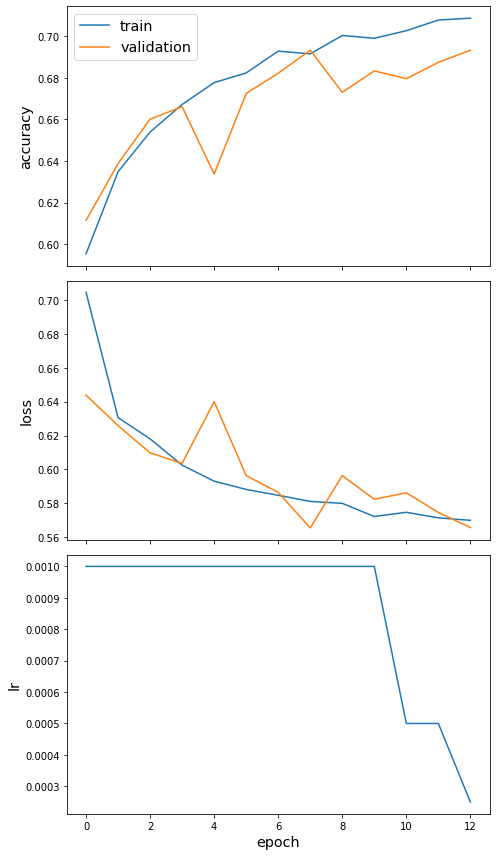

In [ ]:
sg.utils.plot_history(history)

train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


num_tests = 1  # the number of times to generate predictions

all_test_predictions = [
    model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
]

Before calibrating, we calculate the expected calibration error on the test set:

In [ ]:
calibration_data = [calibration_curve(y_prob=test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True)
    for test_predictions in all_test_predictions]


for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_pre_calibration = expected_calibration_error(
        prediction_probabilities=all_test_predictions[0],
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,)
    print("ECE: (before calibration) {:.4f}".format(ece_pre_calibration))

ECE: (before calibration) 0.2894


We will use Platt scaling to calibrate the model:

In [ ]:
num_tests = 1
score_model = keras.Model(inputs=x_inp, outputs=logits)

all_val_score_predictions = [score_model.predict(val_flow, verbose=True) for _ in np.arange(num_tests)]
all_test_score_predictions = [score_model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)]
all_test_probabilistic_predictions = [model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)]

val_predictions = np.mean(np.array(all_val_score_predictions), axis=0)

test_predictions = np.mean(np.array(all_test_score_predictions), axis=0)

# for binary classification this class performs Platt Scaling
lr = TemperatureCalibration()

lr.fit(val_predictions, edge_labels_val)

lr_test_predictions = lr.predict(test_predictions)

calibration_data = [calibration_curve(y_prob=lr_test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True)]

for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_post_calibration = expected_calibration_error(
        prediction_probabilities=lr_test_predictions,
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,)
    print("ECE (after calibration): {:.4f}".format(ece_post_calibration))

ECE (after calibration): 0.4321


Check how the calibration improved the model:

In [ ]:
y_pred = np.zeros(len(test_predictions))

 # the true predictions are the probabilistic outputs
test_predictions = np.mean(np.array(all_test_probabilistic_predictions), axis=0)
y_pred[test_predictions.reshape(-1) > 0.5] = 1
print("Accuracy of model before calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)))

Accuracy of model before calibration: 0.46


In [ ]:
y_pred = np.zeros(len(lr_test_predictions))
y_pred[lr_test_predictions[:, 0] > 0.5] = 1
print("Accuracy for model after calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)))

Accuracy for model after calibration: 0.56
